Saving plant_dataset (1).zip to plant_dataset (1) (2).zip
✅ Dataset extracted successfully!
📁 Classes: ['Healthy', 'Blight', 'Rust', 'Mildew']
✅ Removed 0 corrupted images.
Found 160 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
✅ Classes: {'Blight': 0, 'Healthy': 1, 'Mildew': 2, 'Rust': 3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1880 - loss: 1.5515

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1879 - loss: 1.5464 - val_accuracy: 0.3000 - val_loss: 1.3989
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3300 - loss: 1.3855 - val_accuracy: 0.2750 - val_loss: 1.3972
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3422 - loss: 1.3771 - val_accuracy: 0.3500 - val_loss: 1.4131
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3314 - loss: 1.3723 - val_accuracy: 0.2750 - val_loss: 1.4065
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3210 - loss: 1.3722 - val_accuracy: 0.2500 - val_loss: 1.4032
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4173 - loss: 1.3430 - val_accuracy: 0.2000 - val_loss: 1.4072
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3688 - loss: 1.3409 - val_accuracy: 0.2000 - val_loss: 1.4204
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4388 - loss: 1.2966 - val_accuracy: 0.2250 - val_loss: 1.4210
Epoch 9/10
5/5 ━━━━━━━━━━━━

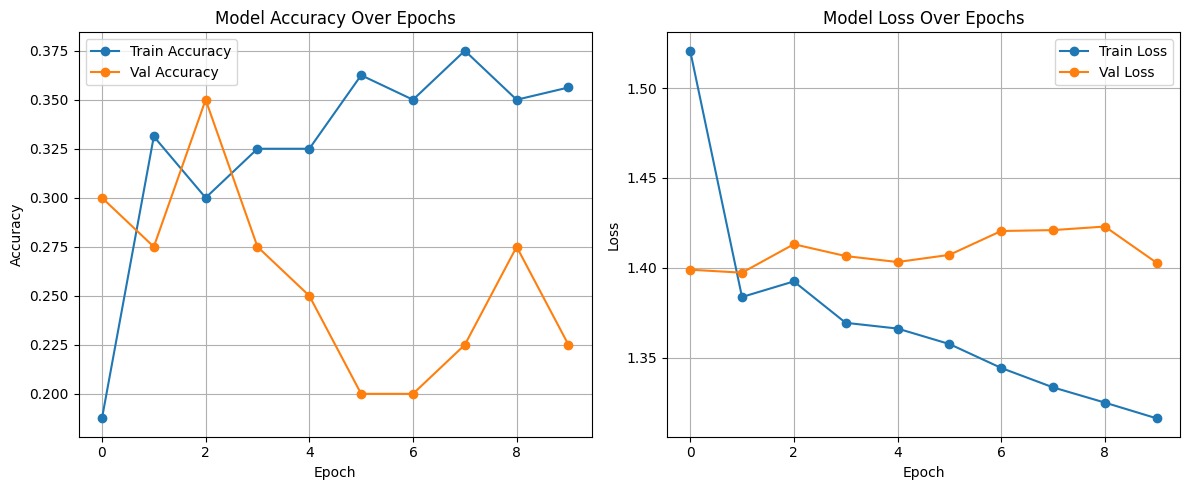

In [12]:
import os
import zipfile
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

# ✅ Upload ZIP
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

# ✅ Extract ZIP
extract_path = "/content/plant_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")
print("📁 Classes:", os.listdir(extract_path))

# ✅ Remove corrupted images
def remove_corrupted_images(folder_path):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError, UnidentifiedImageError):
                os.remove(file_path)
                removed += 1
    print(f"✅ Removed {removed} corrupted images.")

remove_corrupted_images(extract_path)

# ✅ Data Generators (with validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    extract_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    extract_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# ✅ Ensure dataset is not empty
if train_generator.samples == 0:
    raise ValueError("❌ Training dataset is empty!")
if val_generator.samples == 0:
    raise ValueError("❌ Validation dataset is empty!")

print("✅ Classes:", train_generator.class_indices)

# ✅ Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# ✅ Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
